In [1]:
# Datos: http://saludata.saludcapital.gov.co/osb/datos_abiertos_osb/enf-transmisibles/OSB_EnfTransm-COVID-19.csv

In [1]:
import requests
import pandas as pd
import geopandas as gpd

In [22]:
URL = 'http://saludata.saludcapital.gov.co/osb/datos_abiertos_osb/enf-transmisibles/OSB_EnfTransm-COVID-19.csv'
FILEPATH = './data/covid19_bogota_raw.csv'

In [23]:
r = requests.get( URL, stream = True )

with open( FILEPATH, 'wb' ) as f:
    f.write( r.content )

In [24]:
# Loading the data
covid_bog = pd.read_csv( FILEPATH, encoding = 'ISO-8859-1', sep = ';', skiprows = 4, skipfooter = 2 )

/Users/fabian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


In [25]:
covid_bog.columns

Index(['ID de caso', 'Fecha de diagnóstico', 'Ciudad de residencia',
       'Localidad de residencia', 'Edad', 'Sexo', 'Tipo de caso', 'Ubicación',
       'Estado'],
      dtype='object')

In [26]:
covid_bog.shape

(51281, 9)

In [27]:
covid_bog[ 'Fecha de diagnóstico' ] = pd.to_datetime( covid_bog[ 'Fecha de diagnóstico' ], format = '%d/%m/%Y' )

In [28]:
covid_bog[ 'Localidad de residencia' ].replace( { 'Santa Fe': 'Santa Fé' }, inplace = True )

In [29]:
covid_bog.dtypes

ID de caso                          int64
Fecha de diagnóstico       datetime64[ns]
Ciudad de residencia               object
Localidad de residencia            object
Edad                                int64
Sexo                               object
Tipo de caso                       object
Ubicación                          object
Estado                             object
dtype: object

In [30]:
def get_age_group( x ):
    if x <= 19:
        return '0 - 19'
    elif x > 19 and x <= 39:
        return '20 - 39'
    elif x > 39 and x <= 59:
        return '40 - 59'
    elif x > 59 and x <= 79:
        return '60 - 79'
    elif x > 79:
          return '80+'
    else:
        return None

covid_bog[ 'Grupo de edad' ] = covid_bog[ 'Edad' ].apply( get_age_group )

In [31]:
covid_bog.replace( { 'Fallecido (No aplica, No causa Directa)': 'Fallecido' }, inplace = True )

In [32]:
covid_bog.rename( columns = { 'ID de caso': 'ID_caso', 'Fecha de diagnóstico': 'Fecha_diagnostico', 'Ciudad de residencia': 'Ciudad', 'Localidad de residencia': 'Localidad', 'Tipo de caso': 'Tipo', 'Ubicación': 'Atencion', 'Grupo de edad': 'Grupo_de_edad' }, inplace = True )

In [33]:
covid_bog.dtypes

ID_caso                       int64
Fecha_diagnostico    datetime64[ns]
Ciudad                       object
Localidad                    object
Edad                          int64
Sexo                         object
Tipo                         object
Atencion                     object
Estado                       object
Grupo_de_edad                object
dtype: object

In [34]:
covid_bog.tail()

,ID_caso,Fecha_diagnostico,Ciudad,Localidad,Edad,Sexo,Tipo,Atencion,Estado,Grupo_de_edad
51276,51277,2020-07-09,Bogotá,Suba,44,M,En estudio,Casa,Leve,40 - 59
51277,51278,2020-07-09,Fuera de Bogotá,Fuera de Bogotá,55,M,En estudio,Casa,Leve,40 - 59
51278,51279,2020-07-09,Sin Dato,Sin Dato,25,F,En estudio,Casa,Leve,20 - 39
51279,51280,2020-07-09,Sin Dato,Sin Dato,27,M,En estudio,Casa,Leve,20 - 39
51280,51281,2020-07-03,Bogotá,Fontibón,63,F,En estudio ...,Hospital,Moderado,60 - 79


In [35]:
covid_bog.sort_values( by = 'Fecha_diagnostico' ).head( 10 )

,ID_caso,Fecha_diagnostico,Ciudad,Localidad,Edad,Sexo,Tipo,Atencion,Estado,Grupo_de_edad
0,1,2020-03-06,Bogotá,Usaquén,19,F,Importado,Casa,Recuperado,0 - 19
1,2,2020-03-10,Bogotá,Engativá,22,F,Importado,Casa,Recuperado,20 - 39
2,3,2020-03-10,Bogotá,Engativá,28,F,Importado,Casa,Recuperado,20 - 39
3,4,2020-03-12,Bogotá,Fontibón,36,F,Importado,Casa,Recuperado,20 - 39
4,5,2020-03-12,Bogotá,Kennedy,42,F,Importado,Casa,Recuperado,40 - 59
5,6,2020-03-13,Bogotá,Suba,61,F,Importado,Casa,Recuperado,60 - 79
6,7,2020-03-13,Bogotá,Engativá,73,F,Importado,Casa,Recuperado,60 - 79
7,8,2020-03-13,Bogotá,Suba,54,M,Importado,Casa,Recuperado,40 - 59
8,9,2020-03-13,Bogotá,Engativá,54,F,Relacionado,Casa,Recuperado,40 - 59
30,31,2020-03-13,Bogotá,Engativá,37,M,Relacionado,Casa,Recuperado,20 - 39


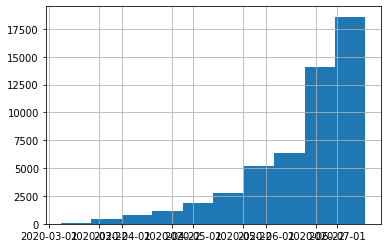

In [36]:
covid_bog[ 'Fecha_diagnostico' ].hist()

In [37]:
covid_bog[ 'Atencion' ].unique()

array(['Casa', 'Fallecido', 'Hospital', 'Hospital UCI',
       'Casa                                                                                                                                                                                                    '],
      dtype=object)

In [20]:
covid_bog.to_csv( './data/covid19_bogota.csv', index = False )